
# Proyecto ML (Airbnb Seattle) — Fase 3 — Preparación de los Datos
**Asignatura:** Machine Learning (MLY0100)  
**Dataset:** Airbnb Seattle (Kaggle)  
**Ruta esperada de datos:** `data/01_raw/listings.csv`, `calendar.csv`, `reviews.csv`

> Este notebook sigue la rúbrica: 3 notebooks (uno por fase) y usa pandas, numpy, matplotlib, seaborn, plotly, scikit-learn.


In [1]:

# Librerías principales
import warnings; warnings.filterwarnings("ignore")
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, r2_score,
    accuracy_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

# Funciones de apoyo
def clean_price(s: pd.Series):
    if s.dtype == object:
        s = s.str.replace(r"[\$,]", "", regex=True)
    return pd.to_numeric(s, errors="coerce")

def parse_bool_t_f(series: pd.Series):
    return series.map({"t": True, "f": False}).astype("boolean")

def add_date_parts(df: pd.DataFrame, col: str):
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")
        df[f"{col}_year"]  = df[col].dt.year
        df[f"{col}_month"] = df[col].dt.month
        df[f"{col}_dow"]   = df[col].dt.dayofweek
    return df


In [ ]:
# Rutas de trabajo
from pathlib import Path

# Detecta si estoy en la raíz del repo o dentro de notebooks/
CWD = Path.cwd().resolve()
if (CWD / "data" / "01_raw").exists():
    DATA = CWD / "data"
elif (CWD.parent / "data" / "01_raw").exists():
    DATA = CWD.parent / "data"         
else:
    raise FileNotFoundError("No encontré la carpeta data/01_raw ni en CWD ni en su padre.")

RAW      = DATA / "01_raw"
PRIMARY  = DATA / "03_primary"
INTER    = DATA / "02_intermediate"
FEATURE  = DATA / "04_feature"
MODELIN  = DATA / "05_model_input"

PRIMARY.mkdir(parents=True, exist_ok=True)

LISTINGS = RAW / "listings.csv"
CALENDAR = RAW / "calendar.csv"
REVIEWS  = RAW / "reviews.csv"

import pandas as pd
listings = pd.read_csv(LISTINGS, low_memory=False)
calendar = pd.read_csv(CALENDAR, parse_dates=["date"], low_memory=False)
reviews  = pd.read_csv(REVIEWS,  parse_dates=["date"], low_memory=False)


# Limpieza de precios
if "price" in listings.columns:
    listings["price_float"] = clean_price(listings["price"])

for c in ["weekly_price","monthly_price","security_deposit","cleaning_fee","extra_people"]:
    if c in listings.columns:
        listings[c] = clean_price(listings[c])

# Conversión de columnas booleanas
for b in ["instant_bookable","host_is_superhost"]:
    if b in listings.columns and listings[b].dtype == object:
        listings[b] = parse_bool_t_f(listings[b])

# Transformación de fechas
for dcol in ["last_scraped","host_since","first_review","last_review"]:
    if dcol in listings.columns:
        listings = add_date_parts(listings, dcol)


### Dataset de Regresión (price)

In [8]:

# Selección de variables numéricas y categóricas
num_cols = [c for c in [
    "accommodates","bathrooms","bedrooms","beds",
    "number_of_reviews","review_scores_rating",
    "weekly_price","monthly_price","security_deposit","cleaning_fee","extra_people"
] if c in listings.columns]

cat_cols = [c for c in ["room_type","neighbourhood_cleansed","property_type"] if c in listings.columns]

# Construcción de dataset
X_reg = listings[num_cols + cat_cols].copy()
y_reg = listings["price_float"].copy()

mask = ~y_reg.isna()
X_reg, y_reg = X_reg[mask], y_reg[mask]

for c in X_reg.columns:
    if str(X_reg[c].dtype) == "boolean":
        X_reg[c] = X_reg[c].astype(float).fillna(0.0)

# Pipeline de preprocesamiento
pre_num = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])
pre_cat = Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("oh", OneHotEncoder(handle_unknown="ignore"))])

prep_reg = ColumnTransformer([
    ("num", pre_num, [c for c in num_cols if c in X_reg.columns]),
    ("cat", pre_cat, [c for c in cat_cols if c in X_reg.columns]),
])

reg_model = Pipeline([("prep", prep_reg), ("reg", LinearRegression())])

# Entrenamiento y evaluación
Xtr, Xte, ytr, yte = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
reg_model.fit(Xtr, ytr)
preds = reg_model.predict(Xte)

print("=== REGRESIÓN ===")
print("MAE:", round(mean_absolute_error(yte, preds), 2),
      "| R²:", round(r2_score(yte, preds), 3))

# Guardado de dataset limpio
reg_out = PRIMARY / "listings_for_regression.csv"
listings.loc[mask, ["price_float"] + [c for c in X_reg.columns]].to_csv(reg_out, index=False)



=== REGRESIÓN ===
MAE: 31.83 | R²: 0.689


### Dataset de Clasificación (instant_bookable o host_is_superhost)

In [9]:

# Selección de target binario
target_bin = None
for cand in ["instant_bookable","host_is_superhost"]:
    if cand in listings.columns:
        target_bin = cand
        break

if target_bin is None:
    raise ValueError("No se encontró columna binaria")

clf_df = listings.copy()

if clf_df[target_bin].dtype == object:
    clf_df[target_bin] = clf_df[target_bin].map({"t":1,"f":0})
clf_df[target_bin] = clf_df[target_bin].astype(int)

num_c = [c for c in ["price_float","accommodates","bathrooms","bedrooms","beds",
                     "number_of_reviews","review_scores_rating"] if c in clf_df.columns]
cat_c = [c for c in ["room_type","neighbourhood_cleansed","property_type"] if c in clf_df.columns]

X_clf = clf_df[num_c + cat_c].copy()
y_clf = clf_df[target_bin].copy()

mask2 = ~y_clf.isna()
X_clf, y_clf = X_clf[mask2], y_clf[mask2]

for c in X_clf.columns:
    if str(X_clf[c].dtype) == "boolean":
        X_clf[c] = X_clf[c].astype(float).fillna(0.0)

# Pipeline de preprocesamiento
pre_num_clf = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])
pre_cat_clf = Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("oh", OneHotEncoder(handle_unknown="ignore"))])

prep_clf = ColumnTransformer([
    ("num", pre_num_clf, [c for c in num_c if c in X_clf.columns]),
    ("cat", pre_cat_clf, [c for c in cat_c if c in X_clf.columns]),
])

# Split estratificado y entrenamiento
Xtr, Xte, ytr, yte = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

clf = Pipeline([("prep", prep_clf), ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))])
clf.fit(Xtr, ytr)
yp = clf.predict(Xte)

# Resultados de clasificación
print("\n=== CLASIFICACIÓN ===")
print("Target:", target_bin)
print("Accuracy:", round(accuracy_score(yte, yp), 3),
      "| F1:", round(f1_score(yte, yp), 3))
print("\nMatriz de confusión:\n", confusion_matrix(yte, yp))
print("\nReporte de clasificación:\n", classification_report(yte, yp, digits=3))

# ROC-AUC
yp_prob = clf.predict_proba(Xte)[:,1]
print("ROC-AUC:", round(roc_auc_score(yte, yp_prob), 3))

# Guardado de dataset limpio
clf_out = PRIMARY / "listings_for_classification.csv"
clf_df.loc[mask2, [target_bin] + [c for c in X_clf.columns]].to_csv(clf_out, index=False)




=== CLASIFICACIÓN ===
Target: instant_bookable
Accuracy: 0.631 | F1: 0.305

Matriz de confusión:
 [[420 226]
 [ 56  62]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0      0.882     0.650     0.749       646
           1      0.215     0.525     0.305       118

    accuracy                          0.631       764
   macro avg      0.549     0.588     0.527       764
weighted avg      0.779     0.631     0.680       764

ROC-AUC: 0.608


### Justificación de decisiones en preparación
- Se evitó *data leakage* excluyendo `price_float` de las features de regresión.
- Se imputaron valores nulos con la mediana (numéricas) y la moda (categóricas).
- Se aplicó escalado estándar para estabilizar los modelos lineales.
- Se aplicó one-hot encoding a variables categóricas para poder usarlas en los modelos.
- En clasificación se usó `class_weight='balanced'` debido al desbalance de clases.
- Se evaluaron métricas adicionales: Accuracy, F1, Matriz de confusión, Reporte de clasificación y ROC-AUC.

### Visualización de distribución de precios tras limpieza

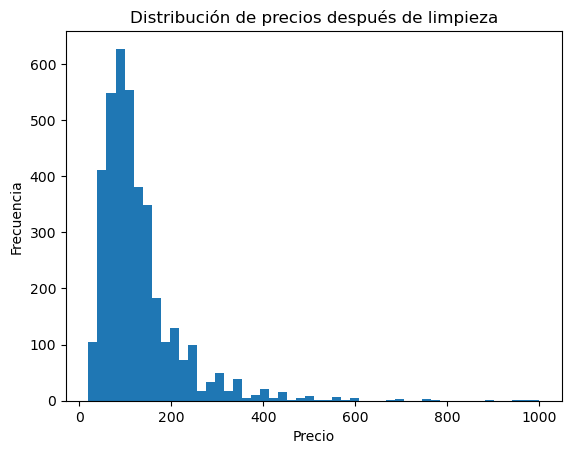

In [10]:
plt.hist(listings['price_float'].dropna(), bins=50)
plt.title('Distribución de precios después de limpieza')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

### Conclusiones de Fase 3
- El dataset quedó preparado para modelado sin leakage.
- Se generaron datasets separados para regresión y clasificación.
- Los resultados iniciales muestran un modelo base con métricas razonables.
- El siguiente paso es integrar estos datasets y pipelines en Kedro para mayor reproducibilidad.